In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import yt
import numpy as np
import os
from astropy import units as u
import cv2 as cv

# Reading data and define volume box

In [12]:
# # read the lowest boundary mask and the highest boundary mask
# timestamp = 200
# lowest_z = 0
# highest_z = 600


# lowest_file = f'/home/joy0921/Desktop/2023S/Dataset/200_210/mask_outputs/{timestamp}/sn34_smd132_bx5_pe300_hdf5_plt_cnt_0{timestamp}_z{lowest_z}/metadata.csv'
# highest_file = f'/home/joy0921/Desktop/2023S/Dataset/200_210/mask_outputs/{timestamp}/sn34_smd132_bx5_pe300_hdf5_plt_cnt_0{timestamp}_z{highest_z}/metadata.csv'


# # define the volums cube (read the coordinate)
# low_x0, low_y0, low_w, low_h = 386,456, 350, 343
# # high: 502 646 216 153


In [35]:
# CV lab
# datadir = "/home/joy0921/Desktop/2023S/Dataset/200_360/finer_time_200_360_original"

# Compute2
datadir = '/home/joy0921/Desktop/Dataset/200_210/raw_data'

filename = "sn34_smd132_bx5_pe300_hdf5_plt_cnt_0201"

ds = yt.load(os.path.join(datadir, filename))

yt : [INFO     ] 2024-01-10 13:44:11,850 Parameters: current_time              = 6030671655459382.0
yt : [INFO     ] 2024-01-10 13:44:11,851 Parameters: domain_dimensions         = [  32   32 1280]
yt : [INFO     ] 2024-01-10 13:44:11,852 Parameters: domain_left_edge          = [-1.54283879e+21 -1.54283879e+21 -6.17135516e+22]
yt : [INFO     ] 2024-01-10 13:44:11,853 Parameters: domain_right_edge         = [1.54283879e+21 1.54283879e+21 6.17135516e+22]
yt : [INFO     ] 2024-01-10 13:44:11,854 Parameters: cosmological_simulation   = 0


In [36]:
ad = ds.all_data()

center =  [0, 0, 0]*yt.units.pc
arb_center = ds.arr(center,'code_length')
left_edge = arb_center - ds.quan(500,'pc')
right_edge = arb_center + ds.quan(500,'pc')

obj = ds.arbitrary_grid(left_edge, right_edge, dims=[1000,1000,1000])
print(obj["flash", "dens"].shape)

(1000, 1000, 1000)


# Import the log file into panda dataframes

In [48]:
import pandas as pd
from glob import glob
import os

# List all .dat files in the current directory
# CV lab
# dat_file_root = "/home/joy0921/Desktop/2023S/Dataset/SNfeedback"

# Compute2.idsl
dat_file_root = "/home/joy0921/Desktop/Dataset/SNfeedback"

# Mac
# dat_file_root = "/Users/joycelynchen/Desktop/UBC/Research/Program/AstroSegTrack/Data/SNfeedback"

dat_files = glob(os.path.join(dat_file_root, "*.dat"))
dat_files = ["/home/joy0921/Desktop/Dataset/SNfeedback/SNfeedback.dat"]


# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Read and concatenate data from all .dat files
for dat_file in dat_files:
    # Assuming space-separated values in the .dat files
    df = pd.read_csv(dat_file, delim_whitespace=True, header=None,
                     names=['n_SN', 'type', 'n_timestep', 'n_tracer', 'time',
                            'posx', 'posy', 'posz', 'radius', 'mass'])
    
    # Convert the columns to numerical
    df = df.iloc[1:]
    df['n_SN'] = df['n_SN'].map(int)
    df['type'] = df['type'].map(int)
    df['n_timestep'] = df['n_timestep'].map(int)
    df['n_tracer'] = df['n_tracer'].map(int)
    df['time'] = pd.to_numeric(df['time'],errors='coerce')
    df['posx'] = pd.to_numeric(df['posx'],errors='coerce')
    df['posy'] = pd.to_numeric(df['posy'],errors='coerce')
    df['posz'] = pd.to_numeric(df['posz'],errors='coerce')
    df['radius'] = pd.to_numeric(df['radius'],errors='coerce')
    df['mass'] = pd.to_numeric(df['mass'],errors='coerce')
    all_data = pd.concat([all_data, df], ignore_index=True)

all_data.head()


,n_SN,type,n_timestep,n_tracer,time,posx,posy,posz,radius,mass
0,1,2,12,0,2.869811e+12,9.763277e+20,1.530785e+21,-1.072755e+21,1.243486e+20,4.098446e+35
1,2,1,20,0,4.796885e+12,-1.145076e+21,-1.434358e+21,-1.205343e+19,3.511398e+19,9.042147e+35
2,3,2,26,0,5.738623e+12,3.977631e+20,-1.337930e+21,4.700837e+20,4.278450e+19,4.298436e+35
3,4,2,34,0,8.607434e+12,-1.120969e+21,1.482572e+21,-1.084808e+20,3.511398e+19,8.470546e+35
4,5,1,40,0,9.592771e+12,1.434358e+21,-8.557934e+20,2.205777e+21,3.085678e+20,4.513983e+33


In [49]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14125 entries, 0 to 14124
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   n_SN        14125 non-null  int64  
 1   type        14125 non-null  int64  
 2   n_timestep  14125 non-null  int64  
 3   n_tracer    14125 non-null  int64  
 4   time        14125 non-null  float64
 5   posx        14125 non-null  float64
 6   posy        14125 non-null  float64
 7   posz        14125 non-null  float64
 8   radius      14125 non-null  float64
 9   mass        14125 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 1.1 MB


In [17]:
# convert seconds to Megayears
def seconds_to_megayears(seconds):
    return seconds / (1e6 * 365 * 24 * 3600)

# Convert pixel value to pc
def pixel2pc(pixel):
    return (pixel * 10) / 8

def cm2pc(cm):
    return cm * 3.24077929e-19

# filter the DataFrame
def filter_data(df, range_coord):
    return df[(df['posx_pc'] > range_coord[0]) & (df['posx_pc'] < range_coord[0] + range_coord[2]) & (df['posy_pc'] > range_coord[1]) & (df['posy_pc'] < range_coord[1] + range_coord[3]) & (df['posz_pc'] > range_coord[4] & (df['posz_pc'] < range_coord[5]))]

def pc2pixel(pc):
    return (pc * 8) / 10

In [50]:
# Convert time to Megayears
all_data['time_Myr'] = seconds_to_megayears(all_data['time'])

# Convert 'pos' from centimeters to parsecs
all_data['posx_pc'] = cm2pc(all_data['posx'])
all_data['posy_pc'] = cm2pc(all_data['posy'])
all_data['posz_pc'] = cm2pc(all_data['posz'])

# Sort the DataFrame by time in ascending order
all_data.sort_values(by='time_Myr', inplace=True)

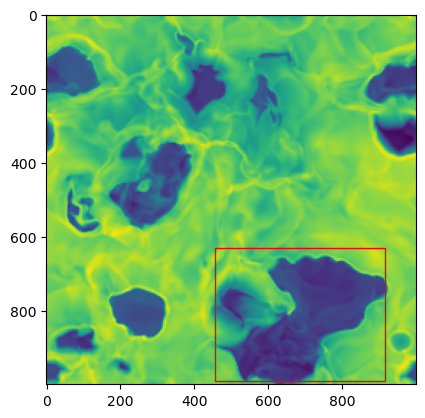

In [53]:
# convert the cube range to pc
low_x0, low_y0, low_w, low_h, bottom_z, top_z = 456,630, 460, 360, -400, 400


# Visualize the selected region on image
# plt.imshow(np.log10(obj["flash", "dens"][:,:,300].T[::-1]))
# plt.colorbar()

# Create figure and axes 
fig, ax = plt.subplots(1) 
  
# Display the image 
ax.imshow(np.log10(obj["flash", "dens"][:,:,300].T[::-1])) 
  
# Create a Rectangle patch 
rect = patches.Rectangle((low_x0, low_y0), low_w, low_h, linewidth=1, 
                         edgecolor='r', facecolor="none")
  
# Add the patch to the Axes 
ax.add_patch(rect) 
plt.show() 

# plt.savefig("density.png")



# low_x0, low_y0, low_w, low_h = pixel2pc(low_x0) - 500, pixel2pc(low_y0) - 500, pixel2pc(low_w), pixel2pc(low_h)
low_x0, low_y0 = low_x0 - 500, low_y0 - 500

In [54]:
low_x0, low_y0, low_w, low_h, bottom_z, top_z 

(-44, 130, 460, 360, -400, 400)

In [55]:
start_yr = 200
end_yr = 202

# Filter data based on specified conditions
filtered_data = filter_data(all_data[(all_data['time_Myr'] >= start_yr) & (all_data['time_Myr'] <= end_yr)],
                            (low_x0, low_y0, low_w, low_h, bottom_z, top_z))
# filtered_data = filter_data(all_data[(all_data['time_Myr'] >= start_yr) & (all_data['time_Myr'] <= end_yr)], (-92, -101, 50, 50, -400, 400))


# Print the resulting DataFrame
filtered_data

,n_SN,type,n_timestep,n_tracer,time,posx,posy,posz,radius,mass,time_Myr,posx_pc,posy_pc,posz_pc
8287,6521,3,50741,1944,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.821904e+35,200.418940,150.390625,240.234373,130.859375
6524,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
8291,6525,3,50797,1995,6.325453e+15,8.618201e+20,1.428331e+21,9.040071e+19,3.511398e+19,3.815084e+35,200.578802,279.296876,462.890617,29.296875
6528,6529,3,50818,0,6.325453e+15,8.618201e+20,1.428331e+21,9.040071e+19,2.998023e+19,4.703975e+35,200.578802,279.296876,462.890617,29.296875
8308,6542,2,51000,1995,6.342943e+15,1.024541e+20,1.042622e+21,4.881638e+20,3.511398e+19,3.601962e+35,201.133406,33.203126,337.890616,158.203126
6545,6546,2,51024,0,6.342943e+15,1.024541e+20,1.042622e+21,4.881638e+20,3.511398e+19,3.624398e+35,201.133406,33.203126,337.890616,158.203126
6549,6550,2,51063,0,6.345812e+15,3.073624e+20,9.100338e+20,6.569118e+20,6.351836e+19,4.129278e+35,201.224375,99.609377,294.921876,212.890625
8312,6546,2,51041,1944,6.345812e+15,3.073624e+20,9.100338e+20,6.569118e+20,6.351836e+19,4.173386e+35,201.224375,99.609377,294.921876,212.890625
6565,6566,3,51215,0,6.360108e+15,1.175209e+21,1.126995e+21,3.555761e+20,1.293607e+20,4.749190e+35,201.677702,380.859364,365.234368,115.234376
8328,6562,3,51199,1944,6.360108e+15,1.175209e+21,1.126995e+21,3.555761e+20,1.195308e+20,4.275656e+35,201.677702,380.859364,365.234368,115.234376


In [65]:
zz = obj['flash','z'][500,500,:].to('pc')

In [66]:
zz

unyt_array([-499.5, -498.5, -497.5, -496.5, -495.5, -494.5, -493.5,
            -492.5, -491.5, -490.5, -489.5, -488.5, -487.5, -486.5,
            -485.5, -484.5, -483.5, -482.5, -481.5, -480.5, -479.5,
            -478.5, -477.5, -476.5, -475.5, -474.5, -473.5, -472.5,
            -471.5, -470.5, -469.5, -468.5, -467.5, -466.5, -465.5,
            -464.5, -463.5, -462.5, -461.5, -460.5, -459.5, -458.5,
            -457.5, -456.5, -455.5, -454.5, -453.5, -452.5, -451.5,
            -450.5, -449.5, -448.5, -447.5, -446.5, -445.5, -444.5,
            -443.5, -442.5, -441.5, -440.5, -439.5, -438.5, -437.5,
            -436.5, -435.5, -434.5, -433.5, -432.5, -431.5, -430.5,
            -429.5, -428.5, -427.5, -426.5, -425.5, -424.5, -423.5,
            -422.5, -421.5, -420.5, -419.5, -418.5, -417.5, -416.5,
            -415.5, -414.5, -413.5, -412.5, -411.5, -410.5, -409.5,
            -408.5, -407.5, -406.5, -405.5, -404.5, -403.5, -402.5,
            -401.5, -400.5, -399.5, -398.5, -397

In [76]:
filtered_data['posz_pc'].iloc[0]

130.85937509844138

In [77]:
np.argmin( np.abs(filtered_data['posz_pc'].iloc[0] - zz.value))

630

In [62]:
obj['flash', 'z'][500,500,130].to('pc')

unyt_quantity(-369.5, 'pc')

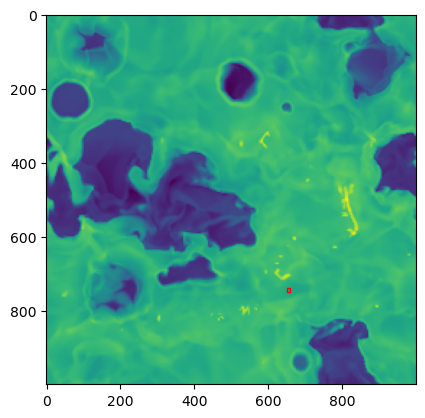

In [78]:
# convert the cube range to pc
low_x0, low_y0, low_w, low_h = 150 + 500, 240 + 500, 10, 10
# low_x0, low_y0, low_w, low_h = 380 + 500, 365 + 500, 10, 10
# low_x0, low_y0, low_w, low_h = pc2pixel(380) + 400, pc2pixel(365) + 400, 10, 10



# Visualize the selected region on image
# plt.imshow(np.log10(obj["flash", "dens"][:,:,300].T[::-1]))
# plt.colorbar()

# Create figure and axes 
fig, ax = plt.subplots() 
  

# Display the image 
ax.imshow(np.log10(obj["flash", "dens"][:,:,630].T[::-1])) 
  
# Create a Rectangle patch 
rect = patches.Rectangle((low_x0, low_y0), low_w, low_h, linewidth=1, 
                         edgecolor='r', facecolor="none")
  
# Add the patch to the Axes 
ax.add_patch(rect) 
plt.show() 


In [20]:
filtered_data.drop_duplicates(subset=['posx_pc', 'n_tracer', 'n_SN'], keep='last')
filtered_data

,n_SN,type,n_timestep,n_tracer,time,posx,posy,posz,radius,mass,time_Myr,posx_pc,posy_pc,posz_pc
45064,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
90882,6521,3,50741,1944,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.821904e+35,200.418940,150.390625,240.234373,130.859375
32617,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
68918,6521,3,50741,1944,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.821904e+35,200.418940,150.390625,240.234373,130.859375
89119,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
53030,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
54793,6521,3,50741,1944,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.821904e+35,200.418940,150.390625,240.234373,130.859375
8287,6521,3,50741,1944,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.821904e+35,200.418940,150.390625,240.234373,130.859375
67155,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375
6524,6525,3,50762,0,6.320412e+15,4.640570e+20,7.412858e+20,4.037898e+20,6.351836e+19,3.832060e+35,200.418940,150.390625,240.234373,130.859375


In [77]:
filtered_data.drop(columns=['posx', 'posy', 'posz', 'time'], inplace=True)
filtered_data.to_csv('SNfeedback_185_200.txt', sep='\t', index=False, encoding='utf-8')

In [64]:
z = cm2pc(-6.17135516e+22)
z
x = cm2pc(-1.54283879e+21)
x

-499.999999844066